# Model the modulation of the internal tide amplitude



In [84]:
import pymc3 as pm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from soda.dataio.conversion import readotps

from scipy.optimize import fmin_powell, fmin, fmin_cg, fmin_ncg

from theano import shared
from theano import tensor as tt

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector


import matplotlib as mpl

In [2]:
%matplotlib notebook

In [3]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'large'

In [4]:
#ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_wout_motion.nc'
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')
ds1

<xarray.Dataset>
Dimensions:   (freqs: 3, modes: 4, time: 264601, timeslow: 728, z: 100)
Coordinates:
  * modes     (modes) int64 0 1 2 3
  * time      (time) datetime64[ns] 2016-04-30 ... 2016-10-30T18:00:00
  * z         (z) float64 0.0 -2.525 -5.051 -7.576 ... -244.9 -247.5 -250.0
  * timeslow  (timeslow) datetime64[ns] 2016-05-01 ... 2016-10-29T18:00:00
  * freqs     (freqs) float64 0.0001405 0.000281 0.0004216
Data variables:
    Atide     (time, modes) float64 ...
    phi       (timeslow, modes, z) float64 ...
    rhofit    (time, z) float64 ...
    r10       (timeslow, modes) float64 ...
    rhobar    (timeslow, z) float64 ...
    amp       (timeslow, modes, freqs) float64 ...
    phs       (timeslow, modes, freqs) float64 ...
    A_n       (time, modes) float64 ...
    N2        (timeslow, z) float64 ...
    cn        (timeslow, modes) float64 ...
Attributes:
    Y:            -13.75895
    ncfile:       /home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Gridd...
    group: 

In [5]:
# Merge the two moorings
A_n = xr.concat([ds1['A_n'][:,0],ds2['A_n'][:,0]], dim='time')
cn = xr.concat([ds1['cn'][:,0],ds2['cn'][:,0]], dim='timeslow')
#N2 = xr.concat([ds1['N2'].mean(axis=-1),ds2['N2'].mean(axis=-1)], dim='timeslow')
N2 = xr.concat([ds1['N2'][:,-1],ds2['N2'][:,-1]], dim='timeslow')

A_n[np.abs(A_n)>80] = 0

<IPython.core.display.Javascript object>


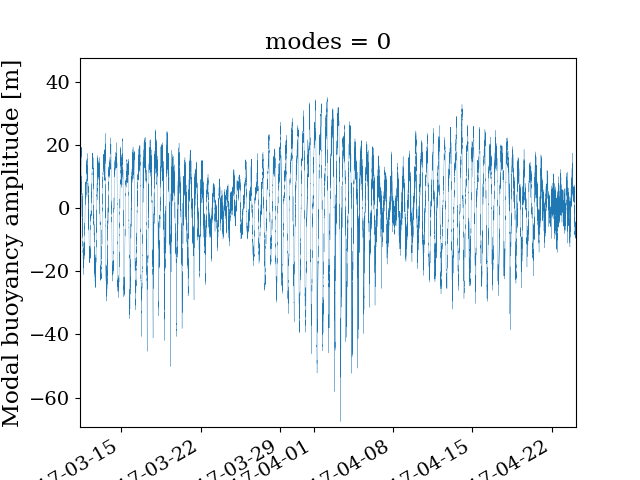

In [6]:
plt.figure()
A_n.plot(lw=0.2)

<IPython.core.display.Javascript object>


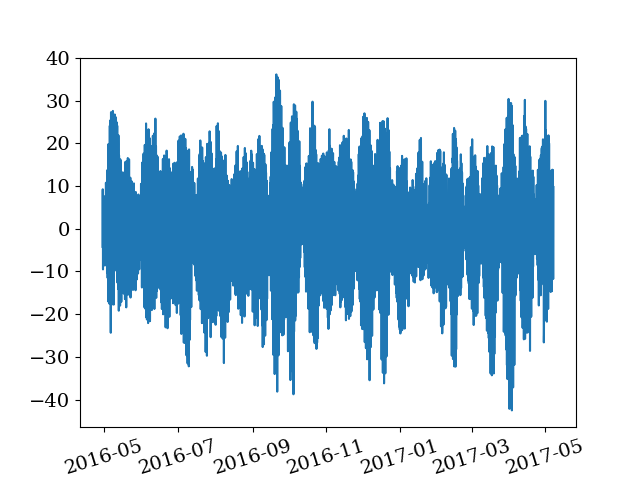

In [7]:
# Subset to hourly (this does a moving average)
#ts = timeseries(A_n.time.values, A_n.values)
A_n_1h = timeseries(A_n.time.values,A_n.values).resample(3600.)

plt.figure()
A_n_1h.plot()

<IPython.core.display.Javascript object>


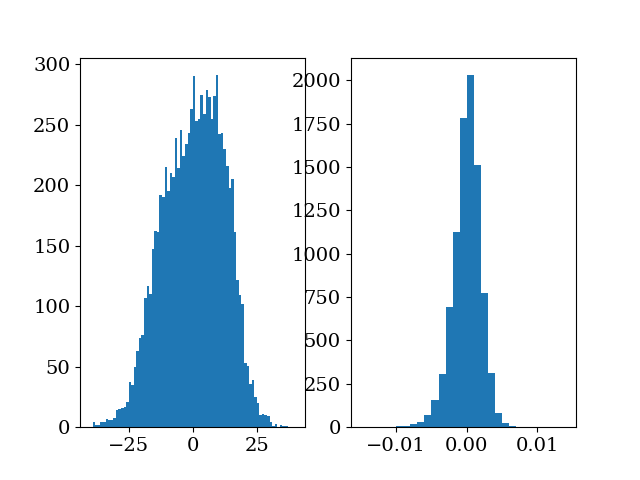

(array([0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 5.000e+00,
        5.000e+00, 1.600e+01, 2.900e+01, 7.300e+01, 1.540e+02, 3.070e+02,
        6.950e+02, 1.128e+03, 1.780e+03, 2.029e+03, 1.514e+03, 7.740e+02,
        3.140e+02, 8.300e+01, 2.400e+01, 8.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([-1.50000000e-02, -1.40000000e-02, -1.30000000e-02, -1.20000000e-02,
        -1.10000000e-02, -1.00000000e-02, -9.00000000e-03, -8.00000000e-03,
        -7.00000000e-03, -6.00000000e-03, -5.00000000e-03, -4.00000000e-03,
        -3.00000000e-03, -2.00000000e-03, -1.00000000e-03,  1.38777878e-17,
         1.00000000e-03,  2.00000000e-03,  3.00000000e-03,  4.00000000e-03,
         5.00000000e-03,  6.00000000e-03,  7.00000000e-03,  8.00000000e-03,
         9.00000000e-03,  1.00000000e-02,  1.10000000e-02,  1.20000000e-02,
         1.30000000e-02,  1.40000000e-02]),
 <a list of 29 Patch objects>)

In [8]:
# Plot the histogram of the amplitude and its derivative
dt = A_n_1h.t[1:]-A_n_1h.t[0:-1]
dt = dt.astype(float)*1e-9
dAdt = (A_n_1h.y[1:]-A_n_1h.y[0:-1])/dt

plt.figure()
#plt.plot(A_n_1h.t[1:],dAdt)
plt.subplot(121)
plt.hist(A_n_1h.y,bins=np.arange(-40,41,1))

plt.subplot(122)
plt.hist(dAdt,bins=np.arange(-0.015,0.015,1e-3))


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


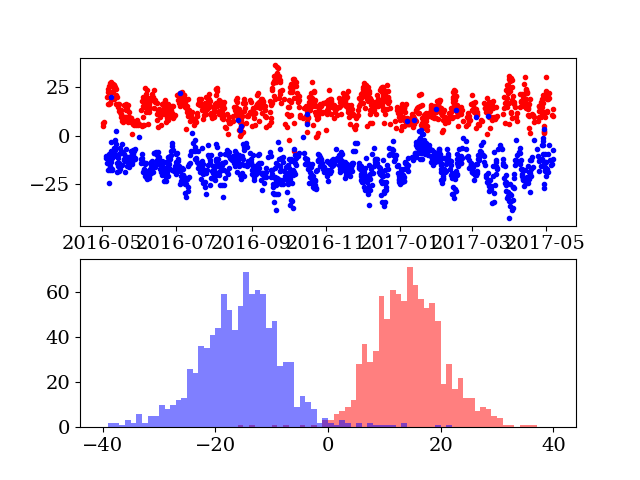

(array([ 0.,  2.,  2.,  1.,  3.,  2.,  6.,  2.,  5.,  5., 10.,  8., 10.,
        12., 13., 26., 24., 36., 35., 41., 44., 59., 52., 43., 54., 69.,
        59., 61., 59., 44., 47., 27., 29., 29.,  9., 14., 11.,  8.,  2.,
         4.,  2.,  1.,  3.,  2.,  0.,  2.,  0.,  2.,  1.,  1.,  1.,  1.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]),
 array([-40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28,
        -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
        -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
         -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40]),
 <a list of 80 Patch objects>)

In [9]:
# find all of the maxima
from scipy import signal
#signal.find_peaks_cwt?
max_peakind =  signal.find_peaks_cwt(A_n_1h.y, np.arange(1,3))
min_peakind =  signal.find_peaks_cwt(-1*A_n_1h.y, np.arange(1,3))


plt.figure()
plt.subplot(211)
plt.plot(A_n_1h.t[max_peakind], A_n_1h.y[max_peakind],'r.')

plt.plot(A_n_1h.t[min_peakind], A_n_1h.y[min_peakind],'b.')

plt.subplot(212)
plt.hist(A_n_1h.y[max_peakind],bins=np.arange(-40,41,1), color='r', alpha=0.5)
plt.hist(A_n_1h.y[min_peakind],bins=np.arange(-40,41,1), color='b', alpha=0.5)

In [91]:
max_peakind =  signal.find_peaks_cwt(A_n_1h.y, np.arange(1,3))
min_peakind =  signal.find_peaks_cwt(-1*A_n_1h.y, np.arange(1,3))

A_n_minmax_u = np.hstack([A_n_1h.y[max_peakind], A_n_1h.y[min_peakind]])
time_minmax_u = np.hstack([A_n_1h.t[max_peakind], A_n_1h.t[min_peakind]])

tidx = np.argsort(time_minmax_u.astype(object))

A_n_minmax_all = A_n_minmax_u[tidx]
time_minmax_all = time_minmax_u[tidx]

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


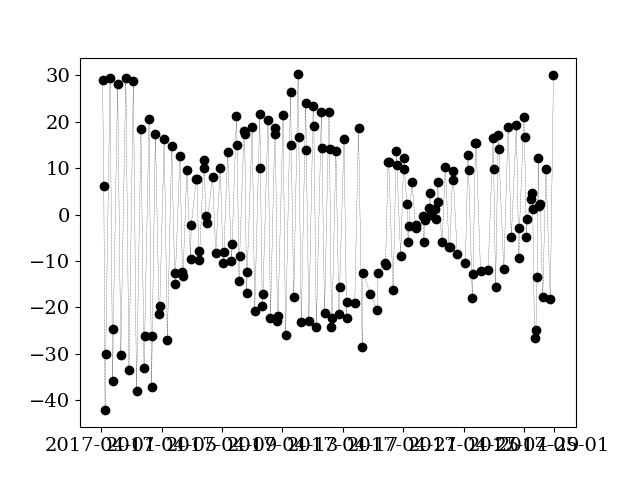

((173,), (173,))

In [90]:
# Put the max/min into one sorted vector
A_n_1h_tmp = A_n_1h.clip(datetime(2017,4,1),datetime(2017,5,1))
#A_n_1h_tmp = A_n_1h

max_peakind =  signal.find_peaks_cwt(A_n_1h_tmp.y, np.arange(1,3))
min_peakind =  signal.find_peaks_cwt(-1*A_n_1h_tmp.y, np.arange(1,3))

A_n_minmax_u = np.hstack([A_n_1h_tmp.y[max_peakind], A_n_1h_tmp.y[min_peakind]])
time_minmax_u = np.hstack([A_n_1h_tmp.t[max_peakind], A_n_1h_tmp.t[min_peakind]])

tidx = np.argsort(time_minmax_u.astype(object))

A_n_minmax = A_n_minmax_u[tidx]
time_minmax = time_minmax_u[tidx]

plt.figure()
plt.plot(time_minmax, A_n_minmax, 'ko',lw=0.2)
plt.plot(time_minmax, A_n_minmax, 'k--',lw=0.2)

time_minmax.shape, A_n_minmax.shape

In [11]:
def sine_model_pm(beta_s, ff, t):
    n = len(ff)

    result = beta_s[0] + beta_s[1]*t
    for ii in range(0,n):
        result += beta_s[2*ii+2]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+3]*pm.math.sin(ff[ii]*t)

    return result

def sine_model_notrend_pm(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0]+0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+2]*pm.math.sin(ff[ii]*t)

    return result
    
def cosine_model_pm(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0]+0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*pm.math.cos(ff[ii] * t - beta_s[2*ii+2])

    return result

def sine_model_notrend(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0] + 0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*np.cos(ff[ii] * t) + beta_s[2*ii+2]*np.sin(ff[ii]*t)

    return result    

class SineModel(pm.gp.mean.Mean):
    def __init__(self, betas, omega):
        self.betas = betas
        self.omega = omega
    def __call__(self, X):
        return tt.squeeze(sine_model_notrend_pm(self.betas, self.omega, X))

In [12]:
# Create a function with similar functionality as harmonic_fit in soda
def harmonic_fit_mcmc(time, X, frqnames, mask=None, axis=0, phsbase=None,         **kwargs):
    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    # Convert the time to days
    dtime = SecondsSince(time, basetime=phsbase )
    
    frq,names = getTideFreq(frqnames)
    
    # Generate initvalues from least-squares fitting
    ts = timeseries(time, X)
    amp, phs, _, _, _, err = ts.tidefit(frqnames=names)
    
    initvals = {'beta_mean':0.}
    initvals = {'sigma':1.}

    ii=-1
    for aa, pp in zip(amp,phs):
        ii+=1
        initvals.update({'beta_amp_%d'%ii:aa})
        initvals.update({'beta_phs_%d'%ii:pp})
    print(initvals)

    
    dtime /= tday
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    #omega = frq
    
    # Number of parameters
    n_params = 2*len(omega) + 1
    
    print('Number of Parametrs: %d\n'%n_params, omega)

    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # Mean
        beta_mean = pm.Normal('beta_mean', mu=0, sd=1)
        # Trend
        #beta_linear = pm.Normal('beta_linear', mu=0, sd=1.)

        #beta_s = [beta_mean, beta_linear]
        beta_s=[beta_mean]

        # Harmonics
        for n in range(0,2*len(omega),2):
            beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=1., sd = 1.))
            beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=1., sd = 1.))
        #for n in range(0,len(omega)):
        #    beta_s.append(BoundNormal('beta_amp_%d'%n,mu=1., sd=10.))
        #    #beta_s.append(pm.Uniform('beta_amp_%d'%n,lower=0, upper=30))
        #    beta_s.append(pm.Uniform('beta_phs_%d'%n, lower=-np.pi, upper=np.pi))

        ###
        # Generate the likelihood function using the deterministic variable as the mean
        #mu_x = cosine_model_pm(beta_s, omega, dtime)
        #mu_x = pm.Deterministic('mu_x', cosine_model_pm(beta_s, omega, dtime))
        mu_x = sine_model_notrend_pm(beta_s, omega, dtime)

        
        #sigma = BoundNormal('sigma', mu=1.,sd=0.25)
        sigma = pm.HalfCauchy('sigma',0.25)
        
        #sigma = 1.0
        X_obs = pm.Normal('X_obs', mu=mu_x, sd=sigma, observed=X)
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=1, observed=X)
        
        #print(pm.find_MAP())

        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        trace = pm.sample(500, tune=1000, start = start, step=step, cores=2,
                         )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
    
   # Calculate statistics of the inferred parameters
    def trace_sd(x):
        return pd.Series(np.std(x, 0), name='sd')
    def trace_mean(x):
        return pd.Series(np.mean(x, 0), name='mean')
    def trace_quantiles(x):
        return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))
    

    params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
    
    # Return the trace and the parameter stats
    return trace, params, my_model

<IPython.core.display.Javascript object>


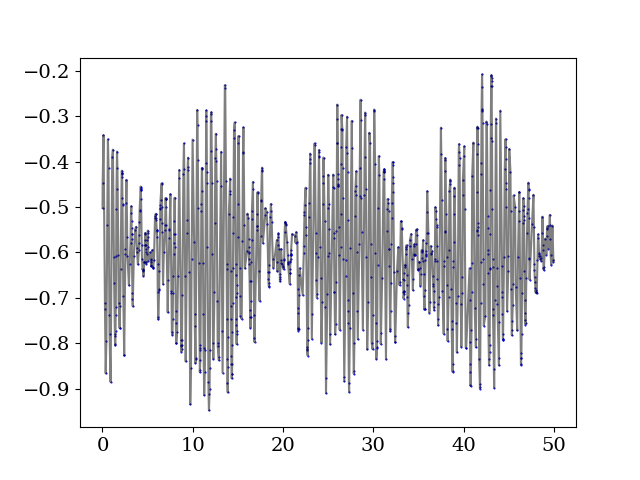

In [51]:
# Create a test time series
n = 1000 # The number of data points
X = 50*np.sort(np.random.rand(n))[:,None]

# Define the true covariance function and its parameters
frq,names = getTideFreq(['M2','S2'])
tday = 86400.
omega = [ff*tday for ff in frq]
beta_s = [0., 0.,0.,0.0,0.]

ℓ_true = 2.0
η_true = 0.5
T_true = 0.5

ℓ_true2 = 2.0
η_true2 = 0.5
T_true2 = 0.517525050851839

ℓ_true3 = 0.10
η_true3 = 0.05

# A mean function that is zero everywhere
#mean_func = SineModel(beta_s, omega)
mean_func = pm.gp.mean.Zero()

cov_func = η_true**2 * pm.gp.cov.Periodic(1, T_true, ls=ℓ_true)
cov_func += η_true2**2 * pm.gp.cov.Periodic(1, T_true2, ls=ℓ_true2)
cov_func += η_true3**2 * pm.gp.cov.Matern52(1, ℓ_true3)



# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 0.0
y = f_true + σ_true * np.random.randn(n)


plt.figure()
plt.plot(X,y, 'bo',ms=0.5)
plt.plot(X, f_true,'k',alpha=0.5)

In [67]:
# GP Implementation
def harmonic_gp_mcmc(time, X, frqnames, mask=None, axis=0, basetime=None,         **kwargs):
    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    # Convert the time to days
    dtime = SecondsSince(time, basetime=basetime )
    
    frq,names = getTideFreq(frqnames)
    
    # Generate initvalues from least-squares fitting
    ts = timeseries(time, X)
    amp, phs, _, _, _, err = ts.tidefit(frqnames=names)
    
    initvals = {'beta_mean':0.}
    initvals = {'sigma':1.}

    ii=-1
    for aa, pp in zip(amp,phs):
        ii+=1
        initvals.update({'beta_amp_%d'%ii:aa})
        initvals.update({'beta_phs_%d'%ii:pp})
    print(initvals)

    
    dtime /= tday
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    #omega = frq
    
    # Number of parameters
    n_params = 2*len(omega) + 1
    
    print('Number of Parametrs: %d\n'%n_params, omega)

    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # Mean
        beta_mean = pm.Normal('beta_mean', mu=0, sd=1)
        # Trend
        #beta_linear = pm.Normal('beta_linear', mu=0, sd=1.)

        #beta_s = [beta_mean, beta_linear]
        beta_s=[beta_mean]
        
        # Use the lstsq as priors
        mu_re = amp*np.cos(phs)
        mu_im = amp*np.sin(phs)

        # Harmonics
        for n in range(0,2*len(omega),2):
            #beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=mu_re[n//2], sd = 1.))
            #beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=mu_im[n//2], sd = 1.))
            beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=0.1, sd = 1.))
            beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=0.1, sd = 1.))

        
        # GP
        #ℓ = BoundNormal("ℓ", mu=10000,sd=10000)
        ℓ = pm.Gamma("ℓ2", alpha=0.1,beta=0.5)

        #T = pm.Gamma("T", alpha=1.,beta=2.)
        η = pm.HalfCauchy("η", beta=1.)

        #cov = η**2 * pm.gp.cov.Periodic(1, T, ls=ℓ)
        cov = η**2. * pm.gp.cov.Matern52(1, ℓ)

        #gp= pm.gp.Marginal(cov_func=cov, )
        gp= pm.gp.Marginal(cov_func=cov, mean_func=SineModel(beta_s, omega))


        sigma = pm.HalfCauchy("sigma", beta=0.25)
        y_ = gp.marginal_likelihood("y", X=dtime[:,None], y=X, noise=sigma)
        
        #sigma = 1.0
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=sigma, observed=X)
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=1, observed=X)
        
        mp = pm.find_MAP()
        print(mp)

        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        trace = pm.sample(500, tune=1500, start = start, step=step, cores=2,)
        #                 )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
        
    # Calculate statistics of the inferred parameters
    def trace_sd(x):
        return pd.Series(np.std(x, 0), name='sd')
    def trace_mean(x):
        return pd.Series(np.mean(x, 0), name='mean')
    def trace_quantiles(x):
        return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))
    

    params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
    #trace = None
    #params = None
    
    # Return the trace and the parameter stats
    return trace, params, my_model, gp,mp
    

In [77]:
def harmonic_gp_nomean_mcmc(time, X, frqnames, mask=None, axis=0, basetime=None,         **kwargs):
    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    # Convert the time to days
    dtime = SecondsSince(time, basetime=basetime )

    dtime /= tday
    
    Ts = [2*np.pi/ff/tday for ff in frq]
    print(Ts)


    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables

    
        # GP
        #ℓ = BoundNormal("ℓ", mu=10000,sd=10000)
        ℓ = pm.Gamma("ℓ", alpha=1.,beta=2.)
        #T = pm.Gamma("T", alpha=1.,beta=2.)
        T = Ts[0]
        η = pm.HalfCauchy("η", beta=1.)
        
        ℓ1 = pm.Gamma("ℓ1", alpha=1.,beta=2.)
        #T1 = pm.Gamma("T1", alpha=1.,beta=2.)
        T1 = Ts[1]
        η1 = pm.HalfCauchy("η1", beta=1.)
        
        ℓ2 = pm.Gamma("ℓ2", alpha=0.1,beta=0.5)
        #T2 = pm.Gamma("T2", alpha=7.,beta=5.)
        η2 = pm.HalfCauchy("η2", beta=1.)


        cov = η**2 * pm.gp.cov.Periodic(1, T, ls=ℓ)
        cov += η1**2 * pm.gp.cov.Periodic(1, T1, ls=ℓ1)
        #cov += η2**2 * pm.gp.cov.Periodic(1, T2, ls=ℓ2)
        cov += η2**2 * pm.gp.cov.Matern52(1, ℓ2)



        #cov = η**2. * pm.gp.cov.ExpQuad(1, ℓ)

        #gp= pm.gp.Marginal(cov_func=cov, )
        gp= pm.gp.Marginal(cov_func=cov, )
        #gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")


        sigma = pm.HalfCauchy("sigma", beta=0.25)
        y_ = gp.marginal_likelihood("y", X=dtime[:,None], y=X, noise=sigma)
        
        #Xu = pm.gp.util.kmeans_inducing_points(100, dtime[:,None])
        #y_ = gp.marginal_likelihood("y", X=dtime[:,None], Xu=Xu, y=X, noise=sigma)
        
        #sigma = 1.0
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=sigma, observed=X)
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=1, observed=X)
        
        mp = pm.find_MAP()
        print(mp)

        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        trace = pm.sample(500, tune=2500, start = start, step=step, cores=2,)
        #                 )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
        
    # Calculate statistics of the inferred parameters
    def trace_sd(x):
        return pd.Series(np.std(x, 0), name='sd')
    def trace_mean(x):
        return pd.Series(np.mean(x, 0), name='mean')
    def trace_quantiles(x):
        return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))
    

    params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
    #trace = None
    #params = None
    
    # Return the trace and the parameter stats
    return trace, params, my_model, gp,mp

In [ ]:

#A_n_test = A_n.sel(time=slice('2017-02-01','2017-03-01'))
#A_n_test = A_n_1h.clip(datetime(2017,2,1),datetime(2017,3,1))
#trace, params, my_model = harmonic_fit_mcmc(A_n_test.t, A_n_test.y, ['M2','S2','K1','O1'])

basetime = datetime(2017,4,1)
#tidecons = ['M2','S2']#,'MSA2','MSB2','MA2','MB2']
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1','MA2','MB2']
#mask = ~A_n_1h.y.mask
#trace, params, my_model = harmonic_gp_mcmc(A_n_1h.t[mask], A_n_1h.y.data[mask], tidecons)
X_sd = A_n_minmax_all.std()
X_mu = A_n_minmax_all.mean()
X = A_n_minmax_all.data - X_mu
X /= X_sd
trace, params, my_model, gp,mp = harmonic_gp_mcmc(time_minmax_all, X, tidecons, basetime=basetime)

#X_sd = A_n_1h.y.std()
#X_mu = A_n_1h.y.mean()
#X = A_n_1h.y.data - X_mu
#X /= X_sd
#trace, params, my_model = harmonic_fit_mcmc(A_n_1h.t, X, tidecons, basetime=basetime)

params

/home/suntans/code/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


{'sigma': 1.0, 'beta_amp_0': 0.9156940330913322, 'beta_phs_0': -1.5896890584352712, 'beta_amp_1': 0.34606451464978, 'beta_phs_1': 0.2432504519460117, 'beta_amp_2': 0.16497079216276309, 'beta_phs_2': 2.908951161069387, 'beta_amp_3': 0.18109561121144663, 'beta_phs_3': -1.8657103415054526, 'beta_amp_4': 0.06741023932345373, 'beta_phs_4': 1.764920556381999, 'beta_amp_5': 0.0559014760100048, 'beta_phs_5': -1.3907315897257098, 'beta_amp_6': 0.029295188363165307, 'beta_phs_6': 1.9224964703495868, 'beta_amp_7': 0.033829487814956385, 'beta_phs_7': -2.7053881876201284, 'beta_amp_8': 0.1622205293823113, 'beta_phs_8': -3.1172664449945238, 'beta_amp_9': 0.12557574367056315, 'beta_phs_9': 2.447572940437536}
Number of Parametrs: 21
 [12.14083317674681, 12.566370614359172, 11.912806035637455, 12.600776206127932, 6.300388082120014, 5.8404450946267925, 6.265982532239158, 5.612417953517441, 12.158035600585768, 12.123630752907852]


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

In [79]:
#pm.model_to_graphviz(my_model)

In [94]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_mean,-0.097612,0.936512,0.026610,-2.142324,1.441908,1269.177105,0.999133
beta_0_re,1.058701,0.989405,0.022844,-0.814094,2.959240,1595.727628,0.999015
beta_0_im,1.002445,0.948853,0.029128,-0.699097,3.001263,966.375687,0.999875
beta_1_re,1.052658,0.954847,0.027188,-0.772640,2.906954,1180.617908,0.999152
beta_1_im,1.047880,0.981644,0.024625,-0.868043,3.040979,1542.409783,0.999130
beta_2_re,0.940575,1.018655,0.028365,-1.077660,2.923458,1194.030842,0.999757
beta_2_im,1.024341,0.998764,0.026039,-0.761117,3.040552,1293.045577,0.999104
beta_3_re,0.904141,0.987799,0.026996,-1.076264,2.766734,1244.830996,0.999269
beta_3_im,0.972720,0.984613,0.026011,-0.980757,2.852781,1435.635593,0.999400
beta_4_re,0.970531,0.963974,0.027490,-0.988396,2.750492,1220.123716,0.999001


<IPython.core.display.Javascript object>


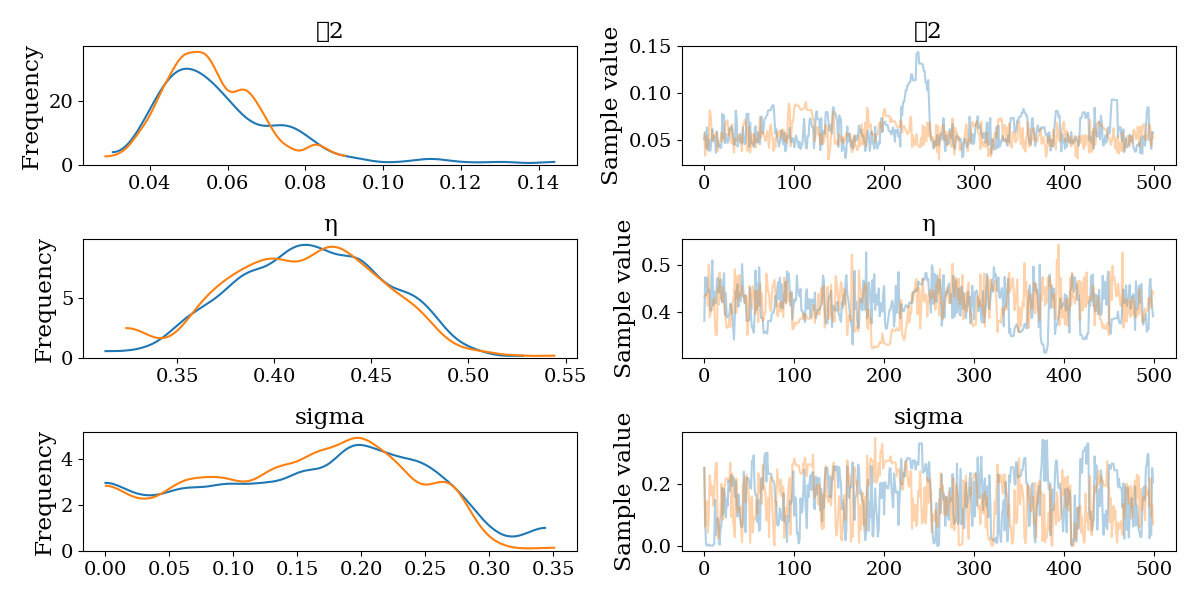

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4be325f28>,
      dtype=object)

In [81]:
pm.traceplot(trace, [
    #'ℓ2',
    'ℓ2',
    'η',
    'sigma',
    #'beta_0_re',
    #'beta_1_re',
    ])

In [86]:
#tout = SecondsSince(A_n_1h_tmp.t, basetime=basetime)
tout = SecondsSince(TimeVector('20170201','20170501',3600,timeformat='%Y%m%d'), basetime=basetime)
tout /= 86400
with my_model:
    fnew2 = gp.conditional("fnew2", Xnew=tout[:,None])

with my_model:
    #ppc = pm.sample_posterior_predictive([mp], samples=100, vars=[fnew])
    ppc = pm.sample_posterior_predictive(trace, samples=100, vars=[fnew2])
    #mu, var = gp.predict(tout, point=mp,  diag=True, pred_noise=True)
    #ppc = pm.sample_posterior_predictive?

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
100%|██████████| 100/100 [21:08<00:00, 12.69s/it]


<IPython.core.display.Javascript object>


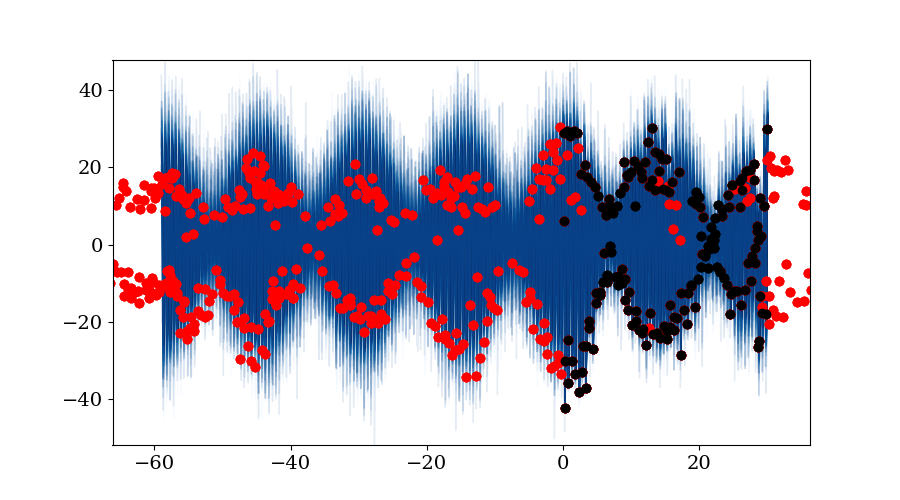

In [92]:
samples = X_sd * ppc["fnew2"] + X_mu
#samples = ppc["fnew"]

time_minmax_sec = SecondsSince(time_minmax, basetime=basetime)
time_minmax_sec /= 86400.

time_minmax_allsec = SecondsSince(time_minmax_all, basetime=basetime)
time_minmax_allsec /= 86400.

fig = plt.figure(figsize=(9,5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples, tout, plot_samples=True, palette="Blues")
ax.plot(time_minmax_allsec, A_n_minmax_all, 'ro',lw=0.2)
ax.plot(time_minmax_sec, A_n_minmax, 'ko',lw=0.2)



In [95]:
def sine_model_trace(trace, ff, t):
    n = len(ff)
    
    result = trace['beta_mean']
    for ii in range(0,n):
        result += trace['beta_%d_re'%(ii)]*np.cos(ff[ii] * t) + trace['beta_%d_im'%(ii)]*np.sin(ff[ii]*t)
        
    #result = np.random.normal(loc=0.0, scale=trace['sigma'], size=result.shape)

    return result  

def cosine_model_trace(trace, ff, t):
    n = len(ff)
    
    result = trace['beta_mean']
    for ii in range(0,n):
        result += trace['beta_amp_%d'%(ii)]*np.cos( ff[ii] * t - trace['beta_phs_%d'%(ii)])
        
    #result += np.random.normal(loc=0.0, scale=np.sqrt(trace['sigma']), size=result.shape)

    return result  

<IPython.core.display.Javascript object>


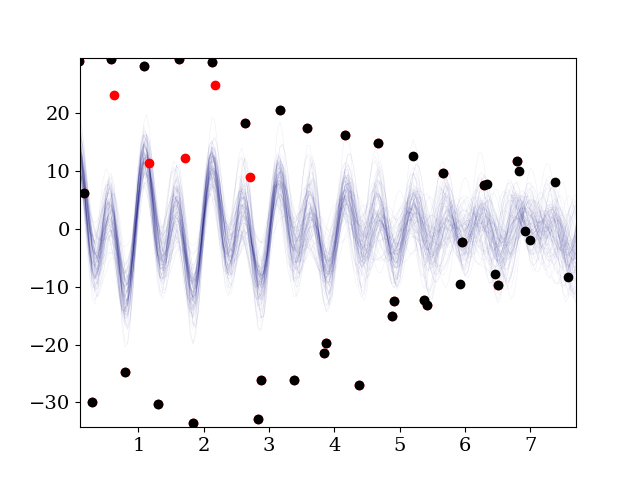

In [104]:
frq,names = getTideFreq(tidecons)

#A_test = sine_model_trace(trace[4],frq, SecondsSince(A_n_1h.t))
nt = A_n_1h.t.shape[0]
nsamples = 500
#A_test = np.zeros((nt,500))
#for ii in range(nsamples):
#    A_test[:,ii] = sine_model_trace(trace[ii],frq, SecondsSince(A_n_1h.t))


plt.figure()
tday = 86400.
omega = [ff*tday for ff in frq]
dtime = SecondsSince(A_n_1h.t,basetime=basetime)/tday

for ii in range(100):
    A_test = sine_model_trace(trace[ii],omega, dtime )
    plt.plot(dtime, A_test,'navy',lw=0.5,alpha=0.05)

#A_n_1h.plot(lw=0.5)

#plt.plot(A_n_1h.t, A_test,'r', lw=0.5,alpha=0.5)
plt.plot(time_minmax_allsec, A_n_minmax_all, 'ro',lw=0.2)
plt.plot(time_minmax_sec, A_n_minmax, 'ko',lw=0.2)

#plt.plot(A_n_1h.t, A_test.mean(axis=1),lw=0.5,alpha=0.5)
#plt.plot(A_n_1h.t, np.percentile(A_test,5,axis=1),'0.5',lw=0.5,alpha=0.9)
#plt.plot(A_n_1h.t, np.percentile(A_test,95,axis=1),'0.5',lw=0.5,alpha=0.9)



In [19]:
# Do a harmonic fit
ts = timeseries(A_n_1h.t[mask], A_n_1h.y.data[mask])
names = ['M2','S2','N2','K2','K1','O1','P1','Q1','MA2','MB2','MSA2','MSB2']
#names = ['M2','S2']


amp, phs, _, _, A_harmonic, err = ts.tidefit(frqnames=names)
amp, err

plt.figure()
A_n_1h.plot(lw=0.5)

plt.plot(ts.t, A_harmonic)

NameError: name 'mask' is not defined

In [98]:
#Calculate the rolling mean of a function
def rolling_std(x,t,freq):
    x_pd = pd.DataFrame(x,index=t)
    return x_pd.rolling(freq, center=False).std().values

In [99]:
def gen_a0(A, err):
    Aerr = np.random.normal(loc=0.0, scale=np.sqrt(err)**2., size=A.shape)
    A_out = A+Aerr
    A_std = rolling_std(A_out, A_n.time.values, '48H').ravel()
    return A_std, A_out

A_std = np.zeros((A_harmonic.shape[0], 3))
for ii in range(3):
    A_std[:,ii], A_out = gen_a0(A_harmonic,err)


plt.figure()

plt.plot(A_n.time, A_n.values)
plt.plot(a0_rms.index, a0_rms.values,'k')

plt.plot(A_n.time.values, A_harmonic+Aerr, lw=0.5, alpha=0.5)
plt.plot(A_n.time.values, A_std.min(axis=1))
plt.plot(A_n.time.values, A_std.max(axis=1))



ValueError: Shape of passed values is (1, 8916), indices imply (1, 534962)

In [ ]:
(np.sqrt(2)*a0_rms).plot

In [104]:
A_n.plot?

# Linear mcmc

In [309]:
RHS=np.sqrt(1000.)
u0 = np.sqrt(uvar)
a0 = np.sqrt(a0_var)

with pm.Model() as individual_model:
    # Intercept prior
    #a = pm.Normal('alpha', mu=0, sd=100)
    # Slope prior
    b = pm.Normal('beta', mu=1, sd=1)

    # Model error prior
    eps = pm.HalfCauchy('eps', beta=1)

    # Linear model
    #a0_est = b * uvar*RHS
    a0_est = b * u0*RHS


    # Data likelihood
    y_like = pm.Normal('y_like', mu=a0_est, sd=eps, observed=a0)

    # Inference button (TM)!
    trace = pm.sample(progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta]
100%|██████████| 1000/1000 [00:01<00:00, 909.70it/s]


<IPython.core.display.Javascript object>


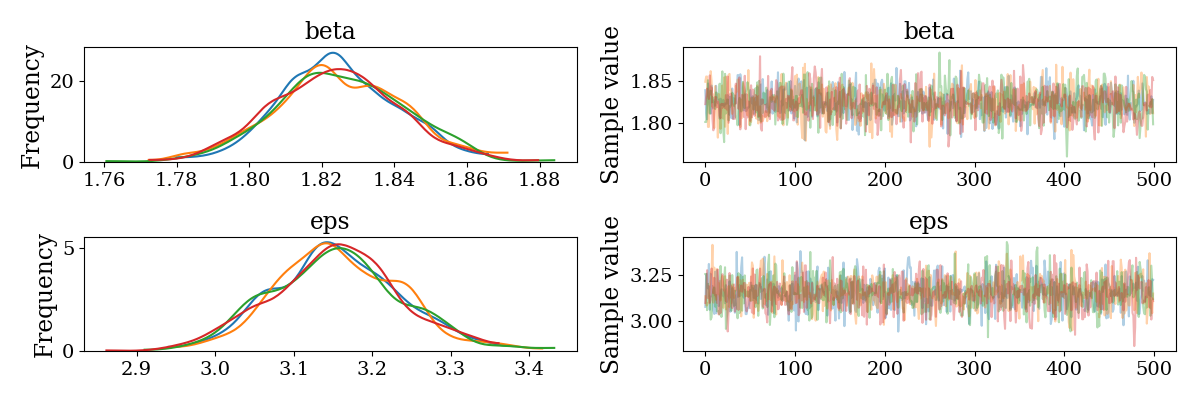

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4e51ed748>,
      dtype=object)

In [310]:
pm.traceplot(trace)

<IPython.core.display.Javascript object>


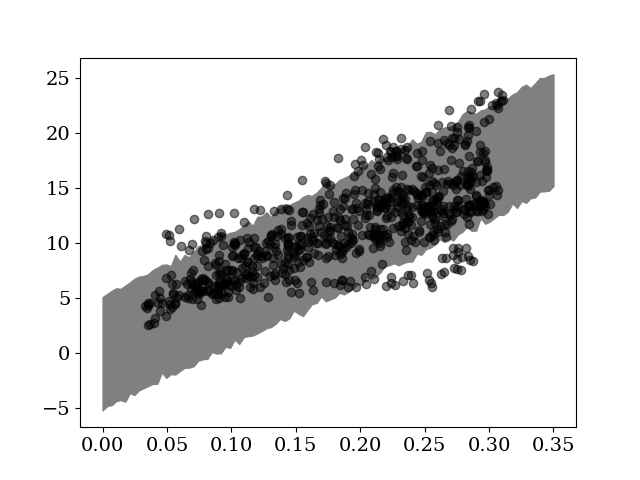

In [313]:
samples = 1000

uvar_test = np.linspace(0,0.35,100)
a0_samples = np.zeros((100, samples))

plt.figure()
ii=-1
for rand_loc in np.random.randint(0, len(trace), samples):
    ii+=1
    rs = trace[rand_loc]
    #a0_guess = rs['alpha'] + rs['beta']*uvar_test + rs['eps']*np.random.randn(100)
    a0_guess = rs['beta']*uvar_test*RHS + rs['eps']*np.random.randn(100)

    #plt.plot(uvar_test, a0_guess,'navy', lw=0.2, alpha=0.5)
    
    a0_samples[:,ii] = a0_guess
    
a5 = np.percentile(a0_samples, 5, axis=-1)
a95 = np.percentile(a0_samples, 95, axis=-1)

plt.fill_between(uvar_test, a5, y2=a95 ,color='0.5')
plt.plot(u0, a0,'ko', alpha=0.5)

In [42]:
a0_mod